In [1]:
import os
import cv2
from pathlib import Path
import random
import torch
import glob
from shutil import copyfile

In [2]:
#Change disk directory
base_path = Path("G:/Dissertation/")
if(Path().cwd() != Path(r"G:\Dissertation")):
    os.chdir(base_path)

In [3]:
#Define data_paths
# raw_data_path = Path("raw_data/Data examples/")
# raw_visibility_path = raw_data_path / Path("1_Visibility/")
# raw_quality_path = raw_data_path/ Path("2_Quality/")
dataset_path = Path('dataset/')

In [4]:
from data_preparation import split_data

data_dir = Path("split_1k/")
split_size = [0.8,0.1,0.1]

#split_data(dataset_path, data_dir, split_size, num_img_class=1000)

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from torchvision import transforms
#Create transform (in this case for the ResNet images are resized to 224x224 and transformed into Tensors)
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal (just to make it as independent from the position of the pipeline)
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [7]:
from dataloaders import create_dataloaders

#Paths criados pelo split_data
train_dir = data_dir / Path('train/')
validation_dir = data_dir / Path('validation/')
test_dir = data_dir / Path('test/')

BATCH_SIZE = 32 # in the ResNet is 128 but my GPU doesn't have enough memory for that

train_dataloader, validation_dataloader, test_dataloader, class_names, train_data, validation_data, test_data = create_dataloaders(train_dir = train_dir,
                                                                                                                                   test_dir = test_dir,
                                                                                                                                   validation_dir = validation_dir,
                                                                                                                                   transform = data_transform,
                                                                                                                                   batch_size = BATCH_SIZE)

In [8]:
torch.cuda.empty_cache()

In [9]:
!nvidia-smi

Fri Feb 17 15:16:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   69C    P8     5W /  N/A |    197MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from engine import train
from ResNet import ResNet50
import torch.nn as nn

# Set number of epochs
NUM_EPOCHS = 5

model_1 = ResNet50().to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model
model_results = train(model=model_1,
                    train_dataloader=train_dataloader,
                    validation_dataloader=validation_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7976 | train_acc: 0.6933 | validation_loss: 0.5215 | validation_acc: 0.7734
Epoch: 2 | train_loss: 0.4781 | train_acc: 0.8060 | validation_loss: 0.3912 | validation_acc: 0.8438
Epoch: 3 | train_loss: 0.3893 | train_acc: 0.8425 | validation_loss: 0.5817 | validation_acc: 0.7223
Epoch: 4 | train_loss: 0.3407 | train_acc: 0.8560 | validation_loss: 0.3202 | validation_acc: 0.8648
Epoch: 5 | train_loss: 0.3183 | train_acc: 0.8622 | validation_loss: 0.2914 | validation_acc: 0.8898
Total training time: 683.691 seconds


In [11]:
model_results

{'train_loss': [0.7975971772670746,
  0.4780571072101593,
  0.3893246006965637,
  0.34071736490726473,
  0.3182971550226212],
 'train_acc': [0.69325, 0.806, 0.8425, 0.856, 0.86225],
 'validation_loss': [0.5214834657672327,
  0.39119978743838146,
  0.5816587430999789,
  0.320232202684565,
  0.2914349701713945],
 'validation_acc': [0.7734375, 0.84375, 0.722265625, 0.86484375, 0.88984375]}

In [12]:
from utils import save_model, eval_model, accuracy_fn

models_path = Path('Models/')
model_name = 'ResNet50_1000_class_5_epoch.pth'

save_model(models_path, model_name, model_1)


model_path = models_path / model_name
loaded_model = ResNet50()
loaded_model.load_state_dict(torch.load(model_path))

Saving the model to: Models\ResNet50_1000_class_5_epoch.pth


<All keys matched successfully>

In [13]:
loaded_model.to(device)

loaded_model_results = eval_model(  model=loaded_model,
                                    data_loader=validation_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device = device)
loaded_model_results



  0%|          | 0/16 [00:03<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.29076895117759705,
 'model_acc': 87.6171875}

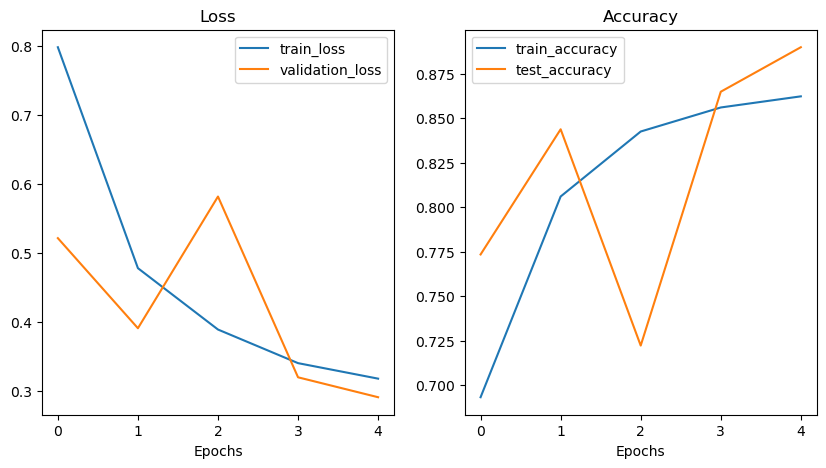

In [14]:
from utils import plot_loss_curves
plot_loss_curves(model_results)

In [15]:
import torchinfo
from torchinfo import summary

summary(model_1, input_size=[128, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 5]                  --
├─Sequential: 1-1                        [128, 64, 56, 56]         --
│    └─Conv2d: 2-1                       [128, 64, 112, 112]       9,472
│    └─BatchNorm2d: 2-2                  [128, 64, 112, 112]       128
│    └─ReLU: 2-3                         [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                    [128, 64, 56, 56]         --
├─Sequential: 1-2                        [128, 256, 56, 56]        --
│    └─ResBlock: 2-5                     [128, 256, 56, 56]        --
│    │    └─Sequential: 3-1              [128, 64, 56, 56]         4,288
│    │    └─Sequential: 3-2              [128, 64, 56, 56]         37,056
│    │    └─Sequential: 3-3              [128, 256, 56, 56]        17,152
│    │    └─ReLU: 3-4                    [128, 256, 56, 56]        --
│    │    └─Sequential: 3-5              [128, 256, 56, 56]        17,

<function utils.plot_confusion_matrix(labels, pred_labels, classes)>

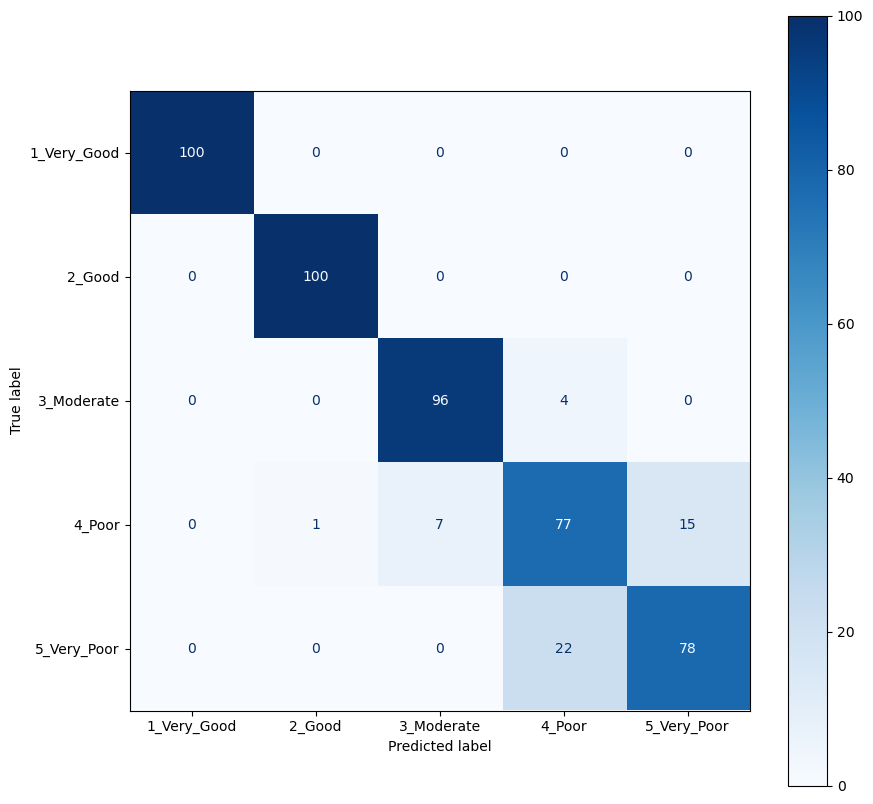

In [16]:
from utils import get_predictions, plot_confusion_matrix

classes = os.listdir(dataset_path)

images, labels, probs = get_predictions(model_1,test_dataloader,device)
pred_labels = torch.argmax(probs, 1) 
plot_confusion_matrix(labels, pred_labels, classes)
plot_confusion_matrix
